# Chapter 3.5.4: An end-to-end example

A linear classifier in pure TensorFlow

https://livebook.manning.com/book/deep-learning-with-python-second-edition/chapter-3/v-5/106

Working through the simple linear classifier outlined in Chapter 3.5.4. The goal of this simple example is to classify two classes of points in a 2D plane. 

In [28]:
import tensorflow as tf
import numpy as np 
import matplotlib.pyplot as plt 

## Generate two classes of random points

First we will randomly generate two classes of random points, and then use a simple linear model to classify them using the tensorflow libary. 

`negative_samples` and `positive_samples` are both arrays with shape `(1000, 2)`. 

In [29]:
# Generate two calsses of random points in a 2D plane
num_samples_per_class = 1000
# Let's label these with the class "zero"
negative_samples = np.random.multivariate_normal(
    mean=[0, 3], cov=[[1, 0.5],[0.5, 1]], size=num_samples_per_class)  
# https://numpy.org/doc/stable/reference/random/generated/numpy.random.multivariate_normal.html
# Generate 1,000 points centered around the point (0,3) 

# Let's label these with the class "one"
positive_samples = np.random.multivariate_normal(
    mean=[3, 0], cov=[[1, 0.5],[0.5, 1]], size=num_samples_per_class)   


Let’s stack them into a single array with shape `(2000, 2)`:

In [30]:
inputs = np.vstack((negative_samples, positive_samples)).astype(np.float32)
# Stack arrays in sequence vertically (row wise).
# https://numpy.org/doc/stable/reference/generated/numpy.vstack.html

Let’s generate the corresponding target labels, an array of zeros and ones of shape `(2000, 1)`, where targets `[i, 0]` is 0 if `inputs[i]` belongs to class 0 (and inversely):

In [31]:
targets = np.vstack((np.zeros((num_samples_per_class, 1), dtype='float32'),
                     np.ones((num_samples_per_class, 1), dtype='float32')))

Now we can display the points using matplotlib. 

The purple points are the points with the class label "zero", while the yellow points are the points with the class label "one".

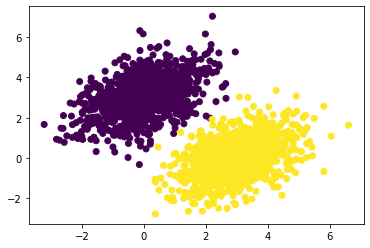

In [32]:
plt.scatter(inputs[:, 0], inputs[:, 1], c=targets[:, 0])
plt.show()

## Define weights and biases, and foward pass function

Now, let’s create a linear classifier that can learn to separate these two blobs. A linear classifier is an affine transformation `prediction = inputs • W + b` trained to minimize the square of the difference between predictions and the targets.

Let's start by creating a random weights and bias tensor.

Since we are dealing with coordinate points in a 2D plane, our input dimension is 2. 

We want to classify the points into one of two cases, "zero" or "one". Since there is one classification, the output dimension is 1. 

In [33]:
input_dim = 2   
output_dim = 1  

# Generate random weights and bias tensors.
W = tf.Variable(initial_value=tf.random.uniform(shape=(input_dim, output_dim)))
b = tf.Variable(initial_value=tf.zeros(shape=(output_dim,)))

print(f"The weights matrix is: \n{W.numpy()}\n")
print(f"The bias matrix is: \n {b.numpy()}")

The weights matrix is: 
[[0.623291  ]
 [0.15869641]]

The bias matrix is: 
 [0.]


Our "forward pass" function simply computes `prediction = inputs • W + b`

W has dimensions (2, 1)

inputs will have the dimensions (2000, 2)

In order to multiply these two matricies, we need to do inputs * W

For each input, (x, y), in inputs, we are computing `(w1, w2) * (x, y) + b = w1+x + w2*y + b`

Thus, we will return a vector of shape (2000, 1), representing the prediction of each point.

In [34]:
print(np.shape(W))
print(np.shape(inputs))

(2, 1)
(2000, 2)


In [35]:
def model(inputs):
    return tf.matmul(inputs, W) + b

## Define square loss function

In this example, we will mesure the loss as the square of the differences between the target and prediction.

`tf.square()` Computes square of x element-wise.

`targets` is a (2000, 1) vector containing either 0 or 1. 

`predictions` is a (2000, 1) vector containing the result of `tf.matmul(inputs, W) + b`

In [36]:
def square_loss(targets, predictions):
    per_sample_losses = tf.square(targets - predictions)   

    # Since we do not specify an axis, we return a single value representing the mean of every element. 
    # https://www.tensorflow.org/api_docs/python/tf/math/reduce_mean
    return tf.reduce_mean(per_sample_losses)               

## Define the training step

The goal of the training step is to update the weights and biases to reduce the loss

We will record the steps we take using a tf [GradientTape](https://www.tensorflow.org/api_docs/python/tf/GradientTape#gradient). Operations are recorded if they are executed within this context manager and at least one of their inputs is being "watched".

In [37]:
learning_rate = 0.1

def training_step(inputs, targets):
    with tf.GradientTape() as tape:
        # Use our forward pass to generate a matrix of predictions
        predictions = model(inputs)
        # Compare the predictions to the target values to determine the total loss
        loss = square_loss(predictions, targets)                     

    # Compute the gradient using operations recorded in context of this tape.
    # https://www.tensorflow.org/api_docs/python/tf/GradientTape#gradient
    grad_loss_wrt_W, grad_loss_wrt_b = tape.gradient(loss, [W, b])   
    # This computes d_loss / d_W and d_loss / d_b

    # Now modify the weights and bias tensors in the direction that reduces loss
    # assign_sub functions like the -= operator
    W.assign_sub(grad_loss_wrt_W * learning_rate)                    
    b.assign_sub(grad_loss_wrt_b * learning_rate)                    

    return loss

## Train the model using batch training

Let's apply the training_step to the entire batch, and watch how it affects the loss.

We can see that after about 30 steps, we start to stabilize a bit. 

In [38]:
epochs = 50
for step in range(epochs):
    loss = training_step(inputs, targets)
    print('Loss at step %d: %.4f' % (step, loss))

Loss at step 0: 0.9771
Loss at step 1: 0.2001
Loss at step 2: 0.1125
Loss at step 3: 0.0968
Loss at step 4: 0.0900
Loss at step 5: 0.0846
Loss at step 6: 0.0798
Loss at step 7: 0.0753
Loss at step 8: 0.0713
Loss at step 9: 0.0675
Loss at step 10: 0.0641
Loss at step 11: 0.0610
Loss at step 12: 0.0581
Loss at step 13: 0.0554
Loss at step 14: 0.0530
Loss at step 15: 0.0507
Loss at step 16: 0.0487
Loss at step 17: 0.0468
Loss at step 18: 0.0451
Loss at step 19: 0.0435
Loss at step 20: 0.0420
Loss at step 21: 0.0407
Loss at step 22: 0.0394
Loss at step 23: 0.0383
Loss at step 24: 0.0372
Loss at step 25: 0.0363
Loss at step 26: 0.0354
Loss at step 27: 0.0346
Loss at step 28: 0.0339
Loss at step 29: 0.0332
Loss at step 30: 0.0326
Loss at step 31: 0.0320
Loss at step 32: 0.0315
Loss at step 33: 0.0310
Loss at step 34: 0.0305
Loss at step 35: 0.0301
Loss at step 36: 0.0297
Loss at step 37: 0.0294
Loss at step 38: 0.0291
Loss at step 39: 0.0288
Loss at step 40: 0.0285
Loss at step 41: 0.0283
Lo

We have designed our model to make a prediction for each point. Since we are minimizing the difference between a prediction value and the label, we will classify predictions as "0" if its prediction value is <= 0.5, and as "1" if it is > 0.5.

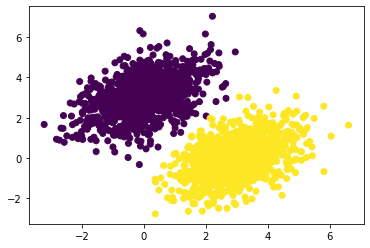

In [39]:
# Get list of predictions using the most recent model
predictions = model(inputs)

# Display plot of points, this time using the predictions as labels, rather than the true label. 
plt.scatter(inputs[:, 0], inputs[:, 1], c=predictions[:, 0] > 0.5)
# The points are labeled based on the boolian prediction > 0.5. If the prediction is > 0.5, then we interpret True as "1". 
plt.show()

Recall that the prediction value for a given point `[x, y]` is simply `prediction == [[w1], [w2]] • [x, y] + b == w1 * x + w2 * y + b`. Thus, class "0" is defined as: `w1 * x + w2 * y + b < 0.5` and class "1" is defined as: `w1 * x + w2 * y + b > 0.5`. You’ll notice that what you’re looking at is really the equation of a line in the 2D plane: `w1 * x + w2 * y + b = 0.5`. Above the line, class 1, below the line, class 0. You may be used to seeing line equations in the format `y = a * x + b`; in the same format, our line becomes: `y = - w1 / w2 * x + (0.5 - b) / w2`.

We can then plot this line in respect to our classified points

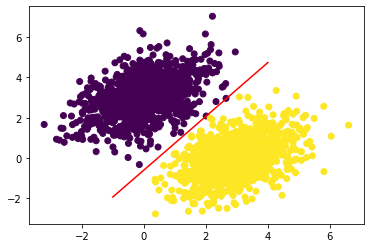

In [40]:
# Let's plot this point in the domain [-1, 4)
x = np.linspace(-1, 4, 100)    

# Compute the points along the line using the point slope form found above
y = - W[0] /  W[1] * x + (0.5 - b) / W[1]    

# -r means red line
plt.plot(x, y, '-r')   
plt.scatter(inputs[:, 0], inputs[:, 1], c=predictions[:, 0] > 0.5)  
plt.show()
